In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
# Import required libraries


In [6]:
df = pd.read_csv('Quality of Service 5G.csv')
df.head()

,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,Video_Call,-75 dBm,30 ms,10 Mbps,15 Mbps,70%
1,9/3/2023 10:00,User_2,Voice_Call,-80 dBm,20 ms,100 Kbps,120 Kbps,80%
2,9/3/2023 10:00,User_3,Streaming,-85 dBm,40 ms,5 Mbps,6 Mbps,75%
3,9/3/2023 10:00,User_4,Emergency_Service,-70 dBm,10 ms,1 Mbps,1.5 Mbps,90%
4,9/3/2023 10:00,User_5,Online_Gaming,-78 dBm,25 ms,2 Mbps,3 Mbps,85%


#### Data Cleaning and Preprocessing

In [7]:
# First, check unique types in categorical feature: Application Type
df['Application_Type'].unique()
#df.info()

array(['Video_Call', 'Voice_Call', 'Streaming', 'Emergency_Service',
       'Online_Gaming', 'Background_Download', 'Web_Browsing',
       'IoT_Temperature', 'Video_Streaming', 'File_Download', 'VoIP_Call'],
      dtype=object)

With this, it shows that our data types are mostly object. We must conver it to numerics

In [8]:
# Transform this into a numerical feature
mapping = {
    'Video_Call': 1,
    'Voice_Call': 2,
    'Streaming': 3,
    'Emergency_Service': 4,
    'Online_Gaming': 5,
    'Background_Download': 6,
    'Web_Browsing': 7,
    'IoT_Temperature': 8,
    'Video_Streaming': 9,
    'File_Download': 10,
    'VoIP_Call': 11
}

df['Application_Type'] = df['Application_Type'].str.strip()
df['Application_Type'] = df['Application_Type'].map(mapping)
df.head()



,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,1,-75 dBm,30 ms,10 Mbps,15 Mbps,70%
1,9/3/2023 10:00,User_2,2,-80 dBm,20 ms,100 Kbps,120 Kbps,80%
2,9/3/2023 10:00,User_3,3,-85 dBm,40 ms,5 Mbps,6 Mbps,75%
3,9/3/2023 10:00,User_4,4,-70 dBm,10 ms,1 Mbps,1.5 Mbps,90%
4,9/3/2023 10:00,User_5,5,-78 dBm,25 ms,2 Mbps,3 Mbps,85%


In [9]:
# Signal Strength
df["Signal_Strength"] = df["Signal_Strength"].str.replace(" dBm", "").astype(float)
# Latency
df["Latency"] = df["Latency"].str.replace(" ms", "").astype(float)

# Resource Allocation
df["Resource_Allocation"] = df["Resource_Allocation"].str.replace("%", "").astype(float)


# function to parse the bandwidth strings
def parse_bandwidth(bw_string):
    if "Mbps" in bw_string:
        return float(bw_string.replace(" Mbps", ""))
    elif "Kbps" in bw_string:
        # Convert from Kbps to Mbps: 1 Mbps = 1000 Kbps
        return float(bw_string.replace(" Kbps", "")) / 1000.0
    else:
        return None

df["Required_Bandwidth"] = df["Required_Bandwidth"].apply(parse_bandwidth)
df["Allocated_Bandwidth"] = df["Allocated_Bandwidth"].apply(parse_bandwidth)

df.head()



,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,1,-75.0,30.0,10.0,15.00,70.0
1,9/3/2023 10:00,User_2,2,-80.0,20.0,0.1,0.12,80.0
2,9/3/2023 10:00,User_3,3,-85.0,40.0,5.0,6.00,75.0
3,9/3/2023 10:00,User_4,4,-70.0,10.0,1.0,1.50,90.0
4,9/3/2023 10:00,User_5,5,-78.0,25.0,2.0,3.00,85.0


In [10]:
# verify changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            400 non-null    object 
 1   User_ID              400 non-null    object 
 2   Application_Type     400 non-null    int64  
 3   Signal_Strength      400 non-null    float64
 4   Latency              400 non-null    float64
 5   Required_Bandwidth   400 non-null    float64
 6   Allocated_Bandwidth  400 non-null    float64
 7   Resource_Allocation  400 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 25.1+ KB


- With this, we have ommited Signal_Strength label (dBm) and Latency label (ms) for better processing of data
- We also first converted to a standard bandwidth, Mbps, then removed the label
- Also converted the Resource_Allocation to float instead of object (percentage to float)

##### Check data
- check our QoS Labels if successful
- Use heatmap to check correlation of numerical features. IF there are highly related features, more than 0.8, ommit one to eliminate redundancy.

In [11]:
# Check our data
#df.head()
#df.describe()
#print(df["QoS_Label"].value_counts())
#df.duplicated().sum()
#df.tail()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            400 non-null    object 
 1   User_ID              400 non-null    object 
 2   Application_Type     400 non-null    int64  
 3   Signal_Strength      400 non-null    float64
 4   Latency              400 non-null    float64
 5   Required_Bandwidth   400 non-null    float64
 6   Allocated_Bandwidth  400 non-null    float64
 7   Resource_Allocation  400 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 25.1+ KB


<Axes: >

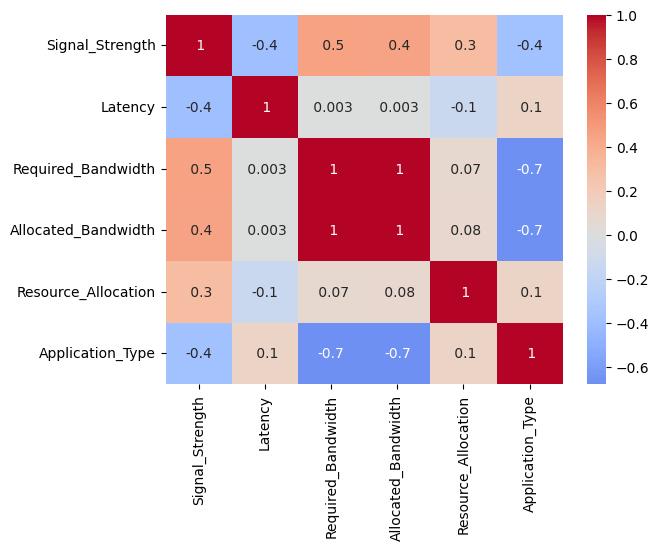

In [18]:
numeric_cols = ['Signal_Strength','Latency','Required_Bandwidth','Allocated_Bandwidth','Resource_Allocation', "Application_Type"]

# Compute correlation matrix
corr_matrix = pd.DataFrame(df[numeric_cols],columns=numeric_cols).corr()

sns.heatmap(corr_matrix,
            cmap = 'coolwarm',
            center = 0,
            annot = True,
            fmt = ' .1g')

With the heatmap above, we see that Required_Bandwith and Allocated_Bandwidth is highly correlated (1), this means we can ommit one. In this case we dont include Required_Bandwidth to remove redundancy of features

#### Train-test split
We can now split the dataset with our chosen features
Since our objective is AI-Based Bandwidth Allocation for Optimized Network Traffic

We will do a regression analysis too since our y (Allocated_Bandwidth) is continuous, a percentage

In [25]:
features = ["Latency", "Signal_Strength", "Resource_Allocation"]
X = df[features]  # Features for the model
y = df["Allocated_Bandwidth"]  # Target: float percentage (0–100)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,     # 20% for testing
    random_state=42
)

#### Modeling
We start with Random Forest Regressor
MSE: Average squared difference between predictions and actual values (lower is better).
RMSE: Square root of MSE (often easier to interpret in the same scale as the target).
R²: Coefficient of determination (closer to 1.0 means better fit).

In [27]:
# Random Forest Regression with Grid Search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest best params:", grid_search_rf.best_params_)
print(f"Random Forest -> MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}, MAE: {mae_rf:.2f}")


Random Forest best params: {'max_depth': None, 'n_estimators': 200}
Random Forest -> MSE: 3.54, R²: 0.82, MAE: 0.62


With MSE around 12.58 (RMSE ≈ 3.55) and R² = 0.82, model is performing quite well at predicting Allocated_Bandwidth from the given features.

In [ ]:
import xgboost as xgb
# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)
# Fit the model
grid_search.fit(X_train, y_train)
# Predict
y_pred = grid_search.best_estimator_.predict(X_test)
# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))
mse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
MSE: 3.2914480760664473
MAE: 0.7362453502245246
R²: 0.8358711187949734


In [29]:
# Gradient Boosting Regression with Grid Search
param_grid_gbr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search_gbr = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gbr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_gbr.fit(X_train, y_train)
best_gbr = grid_search_gbr.best_estimator_
y_pred_gbr = best_gbr.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

print("Gradient Boosting best params:", grid_search_gbr.best_params_)
print(f"Gradient Boosting -> MSE: {mse_gbr:.2f}, R²: {r2_gbr:.2f}, MAE: {mae_gbr:.2f}")


Gradient Boosting best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Gradient Boosting -> MSE: 3.20, R²: 0.84, MAE: 0.75



Comparative Analysis:
               Model       MSE        R²       MAE
0      Random Forest  3.542682  0.823343  0.618820
1            XGBoost  3.291448  0.835871  0.736245
2  Gradient Boosting  3.198851  0.840489  0.748642


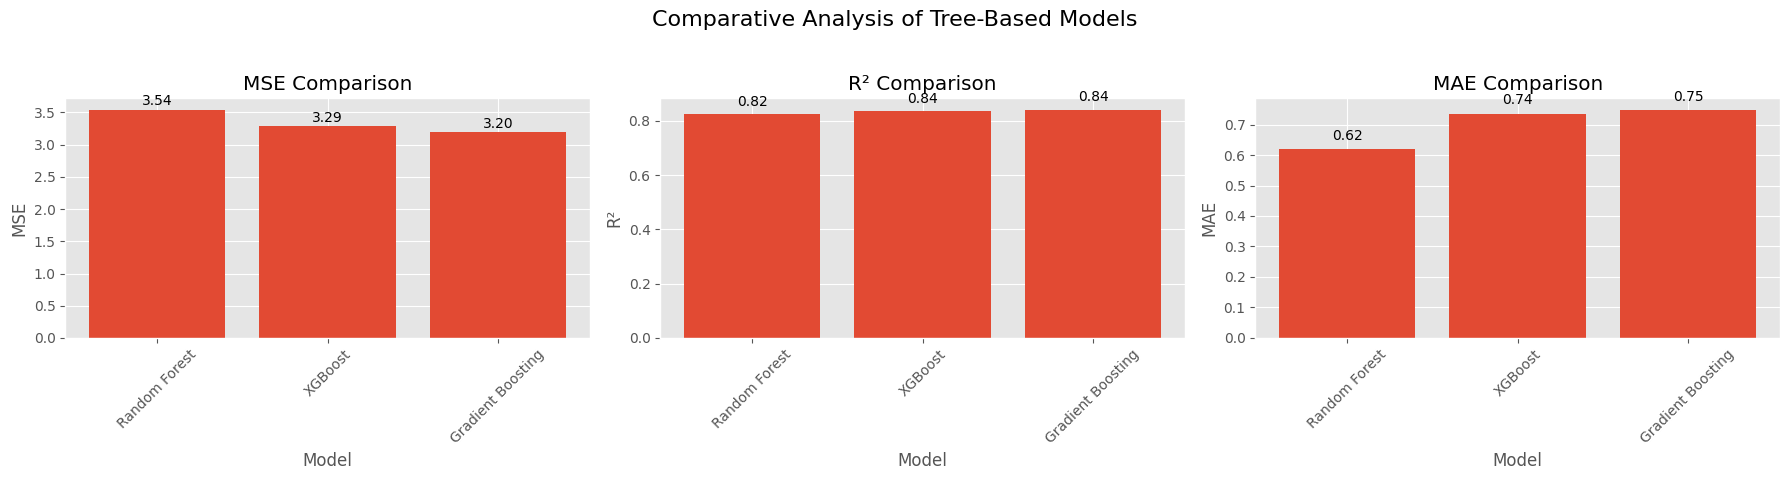

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define your results
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'MSE': [mse_rf, mse_xgb, mse_gbr],
    'R²': [r2_rf, r2_xgb, r2_gbr],
    'MAE': [mae_rf, mae_xgb, mae_gbr]
})

print("\nComparative Analysis:")
print(results)

# Step 2: Plot with value labels
metrics = ['MSE', 'R²', 'MAE']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    bars = axes[i].bar(results['Model'], results[metric])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Model')
    axes[i].set_xticks(range(len(results['Model'])))
    axes[i].set_xticklabels(results['Model'], rotation=45)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width() / 2.0, height + 0.02, f'{height:.2f}', ha='center', va='bottom')

plt.suptitle('Comparative Analysis of Tree-Based Models', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


 - From the table, we can see that Gradient Boosting performed best overall


#### Lets see feature importance using SHAP (only applied to the best model which was Gradient Boosting)
We will use TreeExplainer from shap since Gradient Boosting is a tree based model

In [33]:
import shap
# get SHAP values
explainer = shap.TreeExplainer(best_gbr)

In [34]:
shap_values = explainer(X) 

In [35]:
print(np.shape(shap_values.values))
# Shows (n_samples,n_features)

(400, 3)


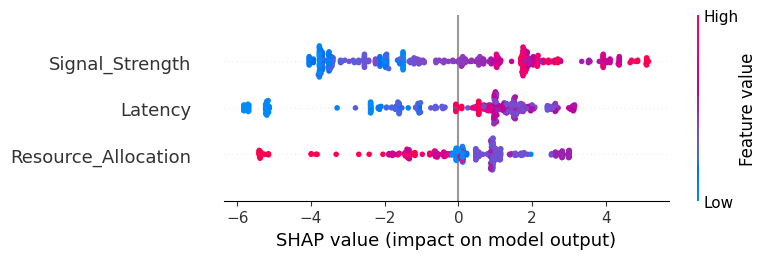

In [36]:
shap.summary_plot(shap_values.values, X)

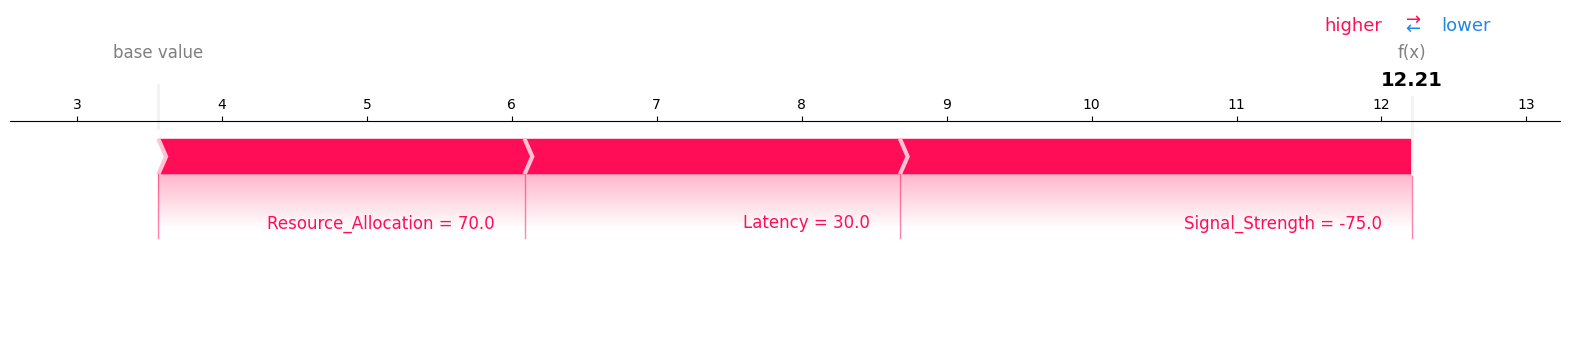

In [37]:
shap.initjs()
i = 0  # examine the first sample
shap.force_plot(
    explainer.expected_value, 
    shap_values.values[i, :], 
    X.iloc[i, :],
    matplotlib=True
)
plt.show()

According to SHAP Summary (Beeswarm) Plot

🔹 Each feature pushes the prediction higher:
All three features — Resource_Allocation, Latency, and Signal_Strength — are contributing positively (in red) to the model's output, which leads to a predicted bandwidth allocation of 12.21.

🔹 Resource_Allocation has the largest impact:
With a value of 70.0, it's the most influential feature here, pushing the prediction significantly upward compared to the base value.

🔹 Base value is the model’s average prediction:
The SHAP visualization starts from the model’s base value (around ~3.5) and shows how each feature shifts the prediction toward the final value (12.21) for this specific instance.
